# Milestone 3 - First Model

In [1]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
from scripts import *
from first_scripts import *
from tqdm import tqdm
import pickle as pkl
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import pairwise_distances_argmin

### I. Data Prepration

In [2]:
# Read the data
# data_path = './data'
data_path = './DLCV_SS25_Dataset'  
images, labels = data_reader(data_path)


In [3]:
num_classes = len(os.listdir(data_path))
num_classes

5

In [4]:
len(images)

2351

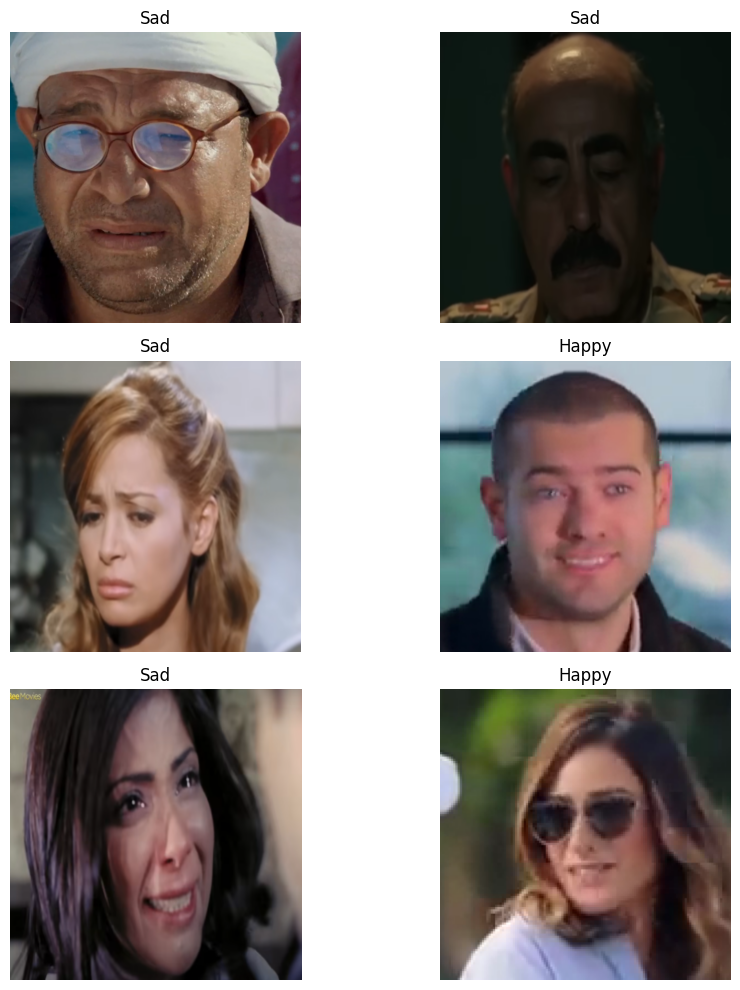

In [5]:
# View 4 random images and their titles
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    img = read_img(images[idx])
    ax.imshow(img)
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple, label_to_index = data_preperator((images, labels))
index_to_label = {v: k for k, v in label_to_index.items()}

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((1645,), (1645,), (470,), (470,), (236,), (236,))

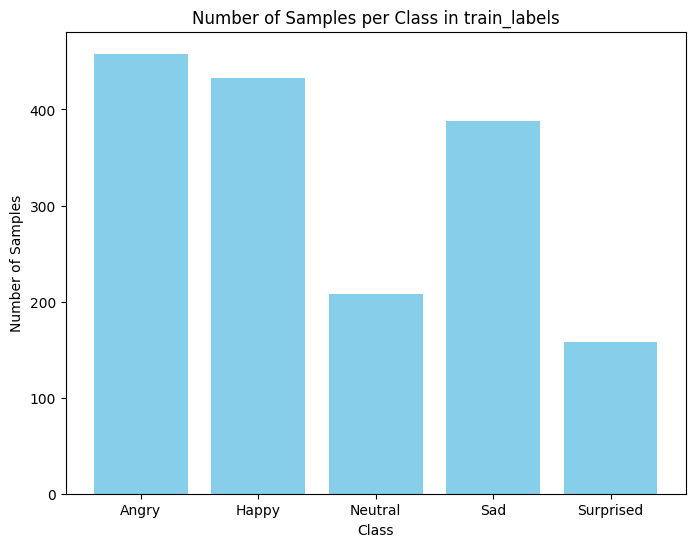

In [7]:
draw_barchart_labels(train_labels, label_to_index)

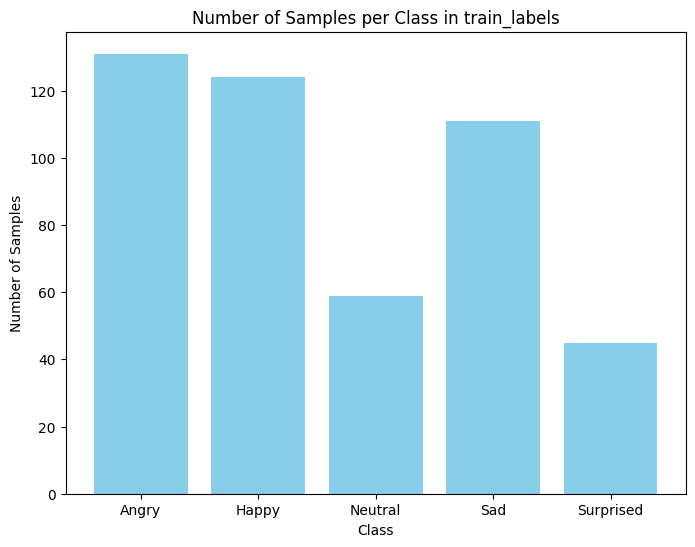

In [8]:
draw_barchart_labels(val_labels, label_to_index)

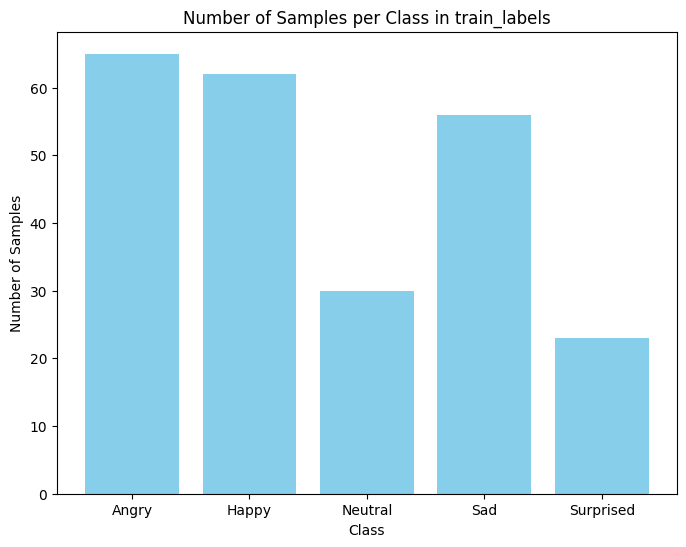

In [9]:
draw_barchart_labels(test_labels, label_to_index)

### II.First Model

In [10]:
# Predefined filters
import numpy as np

base_a = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

base_b = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

base_c = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

base_d = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

base_e = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

filter_a = np.stack([base_a]*3, axis=-1)
filter_b = np.stack([base_b]*3, axis=-1)
filter_c = np.stack([base_c]*3, axis=-1)
filter_d = np.stack([base_d]*3, axis=-1)
filter_e = np.stack([base_e]*3, axis=-1)


filters = [filter_a, filter_b, filter_c, filter_d, filter_e]

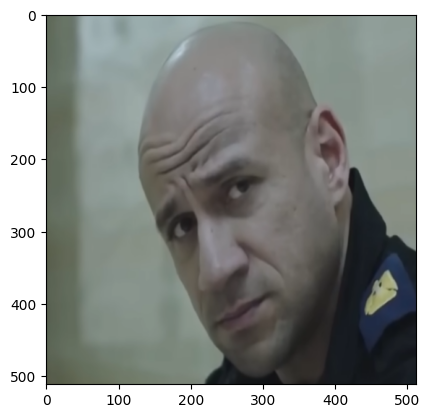

In [11]:
# Get example
path = train_data[0]
img = read_img(path)
# View img
plt.imshow(img) 

In [12]:
# Testing ConvLayer with Random filters
conv_layer = ConvLayer(4, (3, 3, 3))

output = conv_layer.forward(img)
output.shape

(510, 510, 4)

In [ ]:
random_arr = np.random.rand(3, 3, 3)
random_arr_2 = np.random.rand(3, 3, 3)
np.dot(random_arr.flatten(), random_arr_2.flatten())

3.9367464616636925

In [14]:
# Visualize the output of the convolutional layer
conv_layer = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=False)

output = conv_layer.forward(img)
output.shape

(510, 510, 5)

In [15]:
# Check if fast conv and normal conv are the same
conv_layer_fast = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=True)
output_fast = conv_layer_fast.forward(img)
conv_layer_normal = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=False)
output_normal = conv_layer_normal.forward(img)
print(f"Are the outputs the same? {np.equal(output_fast, output_normal).all()}")

Are the outputs the same? True


In [16]:
# Testing the pooling layer
pooling_layer = PoolingLayer(pooling_type='MAX', pool_size=(2, 2))

output = pooling_layer.forward(img)
output.shape

(256, 256, 3)

#### Use Predefined Filters

In [80]:
def extract_features(images_paths: list, model_path: str) -> np.ndarray:
    """
    Extract features from the images using the FirstModel.
    Args:
        data (list): List of image paths.
        model_path (str): Path to the model weights.
    Returns:
        np.ndarray: Extracted features.
    """
    first_model = FirstModel()
    at_once = 20
    output = []
    for i in tqdm(range(0, len(images_paths), at_once), desc="Processing images"):
        batch_end = min(at_once, len(images_paths) - i)
        data = [read_img(images_paths[i + j]) for j in range(batch_end)]
        
        for j in range(len(data)):
            input_img = np.array(data[j])
            output.append(first_model.forward(input_img))

    output = np.array(output)
    if len(output.shape) == 3:
        output = np.squeeze(output, axis=1)
    print(f"Output shape: {output.shape}")
    
    save_model(output, model_path)
    return output

In [78]:
features_path = './features/first_model_features_predefined_weights.pkl'

In [ ]:
with open(features_path, 'wb') as f:
    pkl.dump(output, f)

In [79]:
with open(features_path, 'rb') as f:
    output = pkl.load(f)

In [81]:
test_path = './features/first_model_features_predefined_weights_test.pkl'

In [56]:
test_output = extract_features(test_data, test_path)

Processing images: 100%|██████████| 12/12 [01:12<00:00,  6.00s/it]

Output shape: (236, 128)


In [82]:
with open(test_path, 'rb') as f:
    test_output = pkl.load(f)

In [22]:
from collections import Counter
def map_clusters_to_labels(cluster_ids: np.ndarray, true_labels: np.ndarray) -> Tuple[np.ndarray, Dict[int, int]]:
    """
    Maps cluster IDs to true labels based on the most common true label in each cluster.

    Args:
        cluster_ids (np.ndarray): Array of cluster IDs assigned by KMeans.
        true_labels (np.ndarray): Array of true labels corresponding to the data points.
    
    Returns:
        Tuple[np.ndarray, Dict[int, int]]: A tuple containing:
            - An array of mapped labels for each cluster ID.
            - A dictionary mapping each cluster ID to its most common true label.
    """
    mapped_labels = np.zeros_like(cluster_ids)
    clusters_to_labels = {}
    labels_set = set()
    for cl in np.unique(cluster_ids):
        mask = (cluster_ids == cl)
        mode_labels = Counter(true_labels[mask]).most_common()
        chosen_label = None
        print(f"Cluster {cl}: True labels {mode_labels}")
        for label, _ in mode_labels:
            if label not in labels_set:
                chosen_label = label
                break
        mapped_labels[mask] = chosen_label
        print(f"Cluster {cl}: True label {mapped_labels[mask][0]}")
        clusters_to_labels[cl] = mapped_labels[mask][0]
        labels_set.add(mapped_labels[mask][0])
    return mapped_labels, clusters_to_labels
    
y_pred, cluster_to_labels = map_clusters_to_labels(labels, train_labels)




Cluster 0.0: True labels [(3, 129), (0, 115), (1, 101), (2, 57), (4, 42)]
Cluster 0.0: True label 3.0
Cluster 1.0: True labels [(3, 108), (0, 92), (1, 70), (2, 48), (4, 47)]
Cluster 1.0: True label 0.0
Cluster 2.0: True labels [(1, 70), (0, 42), (2, 22), (3, 22), (4, 12)]
Cluster 2.0: True label 1.0
Cluster 3.0: True labels [(1, 100), (0, 96), (3, 64), (2, 30), (4, 28)]
Cluster 3.0: True label 2.0
Cluster 4.0: True labels [(0, 113), (1, 92), (3, 65), (2, 51), (4, 29)]
Cluster 4.0: True label 4.0


In [42]:
def use_mapping_to_get_test_labels(cluster_to_labels: Dict[int, int], test_labels: np.ndarray) -> np.ndarray:
    """
    Maps the cluster IDs to the true labels using the provided mapping.

    Args:
        cluster_to_labels (Dict[int, int]): A dictionary mapping each cluster ID to its most common true label.
        test_labels (np.ndarray): Array of true labels corresponding to the test data points.
    
    Returns:
        np.ndarray: An array of predicted labels for the test data points.
    """
    mapped_test_labels = np.zeros_like(test_labels)
    for cl, label in cluster_to_labels.items():
        mask = (test_labels == cl)
        mapped_test_labels[mask] = label
    return mapped_test_labels

In [25]:
def plot_cm(cm: np.ndarray):
    """
    Plot the confusion matrix using matplotlib.
    Args:
        cm (np.ndarray): Confusion matrix to plot.
    """
    plt.figure()
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.colorbar()
    # Annotate each cell with the count
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')

#### Use Kmeans from Scratch

##### Train Kmeans for some iters

In [112]:
# Fit kmeans 
X = output
y = train_labels
classes = np.unique(y)  

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeansScratch(n_clusters=5, max_iter=1000)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)

# Get the cluster centers
cluster_centers = kmeans.centroids
# Get the silhouette score
silhouette_avg = silhouette_score(X_scaled, labels)

print(f'Shape of labels: {labels.shape}')
print(f'Shape of cluster centers: {cluster_centers.shape}')
print(f'Number of clusters: {len(cluster_centers)}')
print(f'Silhouette score: {silhouette_avg}')

Shape of labels: (1645,)
Shape of cluster centers: (5, 128)
Number of clusters: 5
Silhouette score: 0.06885049499705724


Cluster 0.0: True labels [(1, 103), (0, 99), (3, 72), (2, 36), (4, 28)]
Cluster 0.0: True label 1.0
Cluster 1.0: True labels [(0, 108), (1, 85), (3, 64), (2, 51), (4, 26)]
Cluster 1.0: True label 0.0
Cluster 2.0: True labels [(3, 87), (0, 81), (1, 76), (2, 36), (4, 26)]
Cluster 2.0: True label 3.0
Cluster 3.0: True labels [(3, 142), (0, 121), (1, 93), (4, 63), (2, 61)]
Cluster 3.0: True label 4.0
Cluster 4.0: True labels [(1, 76), (0, 49), (2, 24), (3, 23), (4, 15)]
Cluster 4.0: True label 2.0
Clustering accuracy for training: 23.40%


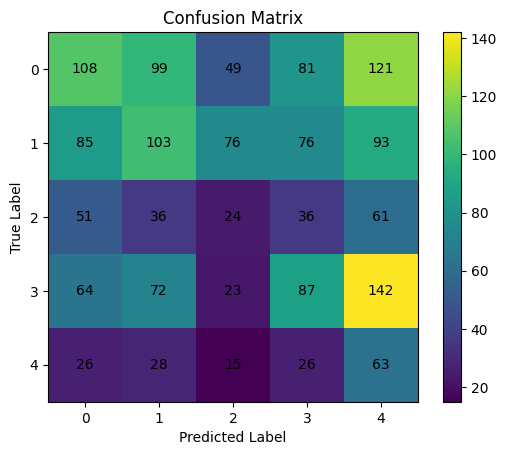

In [113]:
y_pred, cluster_to_labels = map_clusters_to_labels(labels, train_labels)
acc = accuracy_score(train_labels, y_pred)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, y_pred)
plot_cm(cm)

Shape of y_test_pred: (236,), test_labels: (236,)
Clustering accuracy for test: 22.03%


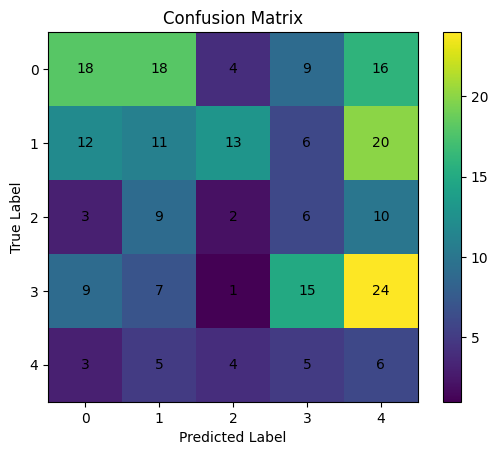

In [114]:
y_test_pred = kmeans.predict(scaler.transform(test_output))
y_test_pred = use_mapping_to_get_test_labels(cluster_to_labels, y_test_pred)
print(f"Shape of y_test_pred: {y_test_pred.shape}, test_labels: {test_labels.shape}")
acc = accuracy_score(test_labels, y_test_pred)
print(f"Clustering accuracy for test: {acc:.2%}")
cm  = confusion_matrix(test_labels, y_test_pred)
plot_cm(cm)

- **Cluster 4 is the top choice for every class** (it has almost the highest count in each row), acting as a “catch-all” cluster.  
- **Poor separation**: samples from each class spread across all clusters, showing the features remain heavily overlapping.

In [100]:
def visualize_clusters(
    true_labels: np.ndarray,
    y_pred: np.ndarray,
    index_to_label: Dict[int, str],
    cluster_to_labels: Dict[int, int],
    images: List[str],
    n_images: int = 16,
):
    """
    Visualize the clusters by showing images from each cluster.
    Args:
        true_labels (np.ndarray): True labels of the images.
        y_pred (np.ndarray): Predicted labels from clustering.
        cluster_to_labels (Dict[int, int]): Mapping from cluster IDs to true labels.
        images (List[str]): List of image paths.
        n_images (int): Number of images to display.
    """
    np.random.seed(42)  # For reproducibility
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(n_images):
        idx = np.random.randint(0, len(images))
        img = read_img(images[idx])
        ax = axes[i // 4, i % 4]
        ax.imshow(img)
        ax.set_title(f"True: {index_to_label[true_labels[idx]]}\nPred: {index_to_label[cluster_to_labels[y_pred[idx]]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

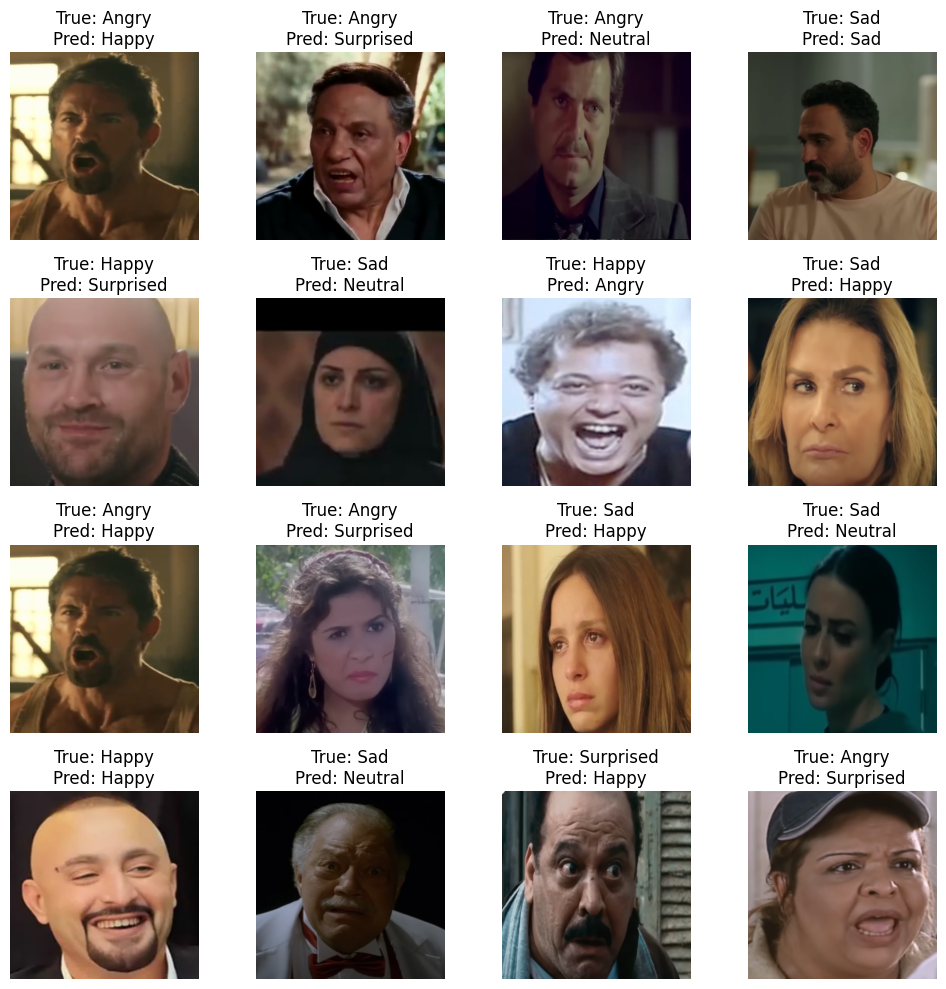

In [101]:
visualize_clusters(
    true_labels=test_labels,
    y_pred=y_test_pred,
    index_to_label=index_to_label,
    cluster_to_labels=cluster_to_labels,
    images=test_data,
    n_images=16
)

##### Use Mean of features as predefined centroids

In [107]:
# X: (n_samples, n_features); y: true labels {0,…,4}
X = output
y = train_labels
classes = np.unique(y)  

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


init_centroids = np.array([X_scaled[y == cls].mean(axis=0) for cls in classes])
print(f"Centroids shape: {init_centroids.shape}")


kmeans = KMeansScratch(
    n_clusters=len(classes),
    init_centroids=init_centroids,
    max_iter=0,
)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)


Centroids shape: (5, 128)


In [108]:
cluster_centers = kmeans.centroids

# calculate distances between init centroids and the cluster centers
distances = np.linalg.norm(init_centroids - cluster_centers, axis=1)
print(f"Distances between init centroids and cluster centers: {distances}")

Distances between init centroids and cluster centers: [0. 0. 0. 0. 0.]


Silhouette score: 0.030080982279966795
Clustering accuracy for training: 29.85%


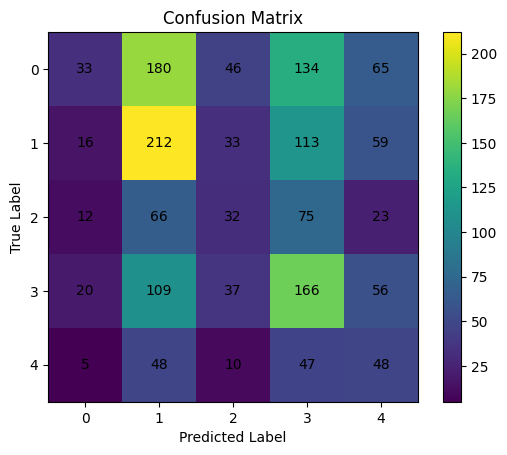

In [109]:
silhouette_avg = silhouette_score(X_scaled, labels)
print(f'Silhouette score: {silhouette_avg}')
acc = accuracy_score(train_labels, labels)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, labels)
plot_cm(cm)

- **Cluster 1 vs. Cluster 3 split**: classes 0 & 1 load mostly into cluster 1 (180 & 212), while classes 2 & 3 favor cluster 3 (75 & 166).  
- **Widespread overlap**: sizeable off-diagonal counts indicate no cluster cleanly isolates any class.

Shape of y_test_pred: (236,), test_labels: (236,)
Clustering accuracy for test: 22.88%


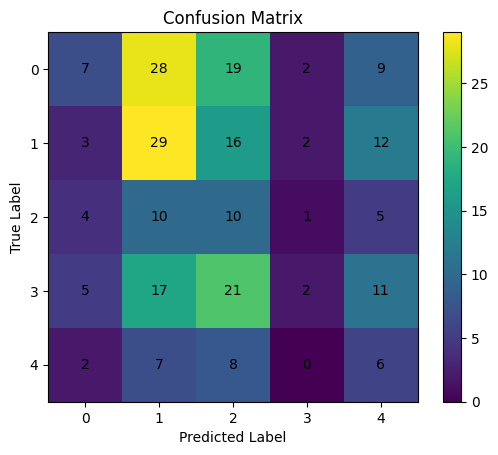

In [111]:
y_test_pred = kmeans.predict(scaler.transform(test_output))
y_test_pred = use_mapping_to_get_test_labels(cluster_to_labels, y_test_pred)
print(f"Shape of y_test_pred: {y_test_pred.shape}, test_labels: {test_labels.shape}")
acc = accuracy_score(test_labels, y_test_pred)
print(f"Clustering accuracy for test: {acc:.2%}")
cm  = confusion_matrix(test_labels, y_test_pred)
plot_cm(cm)

- **Cluster 1 is the “catch-all”**: it has the highest count for every true label (e.g. 28/65 for class 0, 29/62 for class 1).  
- **No clear majority**: even the leading cluster holds under 50% of any class, so none cleanly isolates a label.

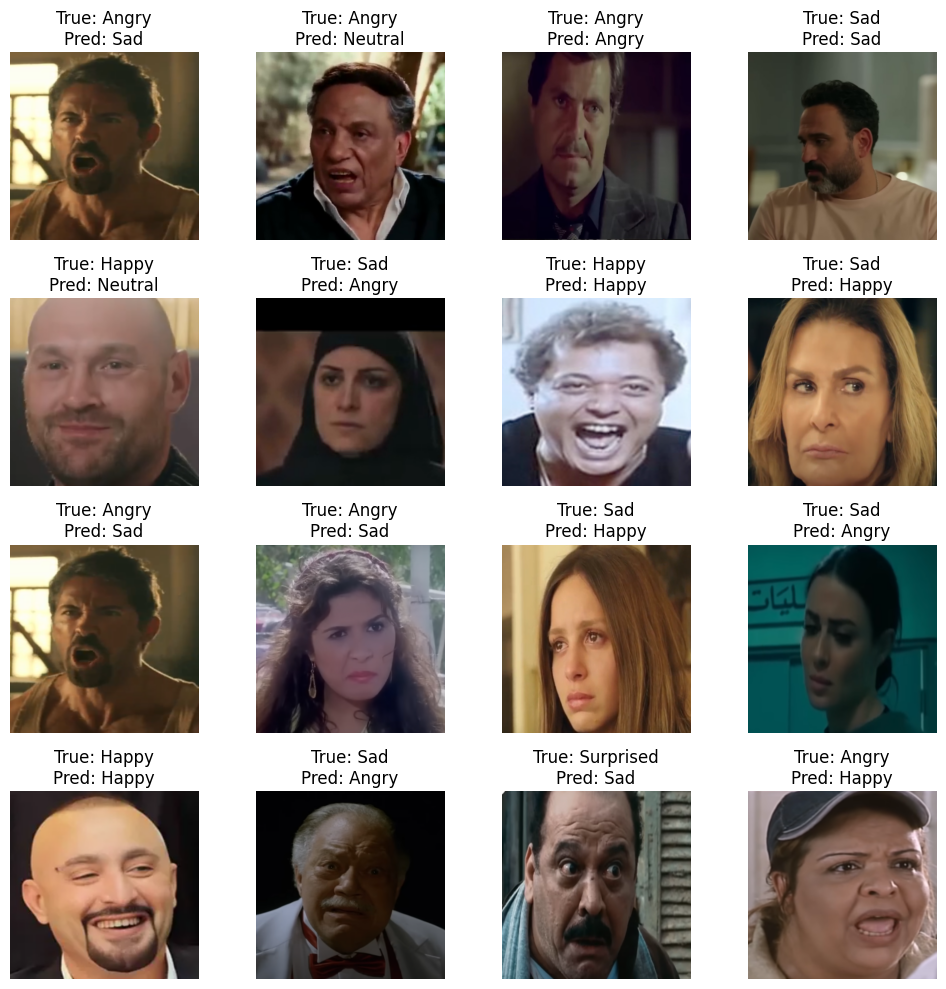

In [106]:
visualize_clusters(
    true_labels=test_labels,
    y_pred=y_test_pred,
    index_to_label=index_to_label,
    cluster_to_labels=cluster_to_labels,
    images=test_data,
    n_images=16
)